Traveling Salesman Problem(TSP)
ECSE 420: Parallel Computing

## IMPORTS

In [ ]:
!pip install dimod -q
!pip install dwave_networkx -q
!pip install dwave-greedy -q
!pip install ortools -q

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import dimod as dm
import dwave_networkx as dnx
import greedy
import itertools
import time
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from functools import lru_cache
from typing import Dict, List, Optional, Tuple


%matplotlib inline

## SETUPS

In [ ]:
seed = 1
np.random.seed(seed)

## DATASETS

data_s: FIVE dataset which is set of 5 cities. This dataset has a minimum tour length of 19.

data_m: P01 dataset which is set of 15 cities. This dataset has a minimum tour length of 291.

data_l: FRI26 dataset which is set of 26 cities with minimum tour length of 937.

data_xl: DANTZIG42 dataset which is set of 42 cities with minimum tour length of 699.

[Link](https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html) to datasets

In [ ]:
data_s = pd.read_csv('https://people.sc.fsu.edu/~jburkardt/datasets/tsp/five_d.txt', sep='\s+', header=None)
data_m = pd.read_csv('https://people.sc.fsu.edu/~jburkardt/datasets/tsp/p01_d.txt', sep='\s+', header=None)
data_l = pd.read_csv('https://people.sc.fsu.edu/~jburkardt/datasets/tsp/fri26_d.txt', sep='\s+', header=None)
data_xl = pd.read_csv('https://people.sc.fsu.edu/~jburkardt/datasets/tsp/dantzig42_d.txt', sep='\s+', header=None)

In [ ]:
data_s.shape

(5, 5)

In [ ]:
data_m.shape

(15, 15)

In [ ]:
data_l.shape

(26, 26)

In [ ]:
data_xl.shape

(42, 42)

## GRAPHS

nodes of the small graph:  [0, 1, 2, 3, 4]
edges of the small graph:  [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


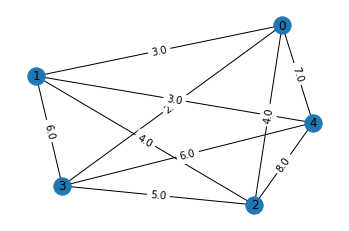

In [ ]:
graph_s =  nx.from_pandas_adjacency(data_s)
pos_s = nx.spring_layout(graph_s, seed=seed)

nodes_s = graph_s.nodes()
edges_s = graph_s.edges()
weights_s = nx.get_edge_attributes(graph_s, 'weight')

plt.axis('off')
nx.draw_networkx(graph_s, pos_s, with_labels=True)
nx.draw_networkx_edge_labels(graph_s, pos_s, edge_labels=weights_s)

print("nodes of the small graph: ", nodes_s)
print("edges of the small graph: ", edges_s)

In [ ]:
graph_m =  nx.from_pandas_adjacency(data_m)
pos_m = nx.spring_layout(graph_m, seed=seed)

nodes_m = graph_m.nodes()
edges_m = graph_m.edges()
weights_m = nx.get_edge_attributes(graph_m, 'weight')

#NOTE: This graph is too large to plot.

In [ ]:
graph_l =  nx.from_pandas_adjacency(data_l)
pos_l = nx.spring_layout(graph_l, seed=seed)

nodes_l = graph_l.nodes()
edges_l = graph_l.edges()
weights_l = nx.get_edge_attributes(graph_l, 'weight')

#NOTE: This graph is too large to plot.

In [ ]:
graph_xl =  nx.from_pandas_adjacency(data_xl)
pos_xl = nx.spring_layout(graph_xl, seed=seed)

nodes_xl = graph_xl.nodes()
edges_xl = graph_xl.edges()
weights_xl = nx.get_edge_attributes(graph_xl, 'weight')

#NOTE: This graph is too large to plot.

## CLASSICAL METHODS

### Exact Algorithms

#### Brute-force

In [ ]:
start = time.time()

# get all iterations
p = itertools.permutations(nodes_s)

min_route = []
min_route_length = -1

for route in list(p):
  tour_len = 0
  for idx, node in enumerate(route[:-1]):
    dist = data_s[route[idx+1]][route[idx]]
    tour_len += dist
  tour_len += data_s[route[0]][route[-1]]

  if min_route_length == -1:
    min_route_length = tour_len
    min_route = route
  else:       
    if min_route_length > tour_len :
      min_route_length = tour_len
      min_route = route
  #print("Route for the tour: ", min_route)
  #print("Minimum tour length using Brute Force: ", min_route_length)
end = time.time()

print("Route for the tour: ", min_route)
print("Minimum tour length using Brute Force: ", min_route_length)
print("Execution Time:  {}s".format(end-start))

Route for the tour:  (0, 2, 1, 4, 3)
Minimum tour length using Brute Force:  19.0
Execution Time:  0.008554697036743164s


#### Dynamic Programming

In [ ]:
#Dynamic Programming Approach 

def solve_tsp_dynamic_programming(
    distance_matrix: np.ndarray,
    maxsize: Optional[int] = None,
) -> Tuple[List, float]:
    # Get initial set {1, 2, ..., tsp_size} as a frozenset because @lru_cache
    # requires a hashable type
    N = frozenset(range(1, distance_matrix.shape[0]))
    memo: Dict[Tuple, int] = {}

    # Step 1: get minimum distance
    @lru_cache(maxsize=maxsize)
    def dist(ni: int, N: frozenset) -> float:
        if not N:
            return distance_matrix[ni, 0]

        # Store the costs in the form (nj, dist(nj, N))
        costs = [
            (nj, distance_matrix[ni, nj] + dist(nj, N.difference({nj})))
            for nj in N
        ]
        nmin, min_cost = min(costs, key=lambda x: x[1])
        memo[(ni, N)] = nmin
        return min_cost

    best_distance = dist(0, N)

    # Step 2: get path with the minimum distance
    ni = 0  # start at the origin
    solution = [0]
    while N:
        ni = memo[(ni, N)]
        solution.append(ni)
        N = N.difference({ni})

    return solution, best_distance

start = time.time()
solution, best_distance = solve_tsp_dynamic_programming(data_s.to_numpy()) #data_s, data_m, or data_l
end = time.time()
# 
print("Route for the tour: ", solution)
print("Minimum tour length using Dynamic Programming ", best_distance)
print("Execution Time:  {}s".format(end-start))

Route for the tour:  [0, 2, 1, 4, 3]
Minimum tour length using Dynamic Programming  19.0
Execution Time:  0.0004031658172607422s


### Meta-Heuristic Algorithms

#### D-Wave NetworkX

In [ ]:
def networkx_solver(data, graph, strategy):
  start = time.time()

  # sampler
  if(strategy == 'GREEDY_DESCENT'):
    sampler = greedy.SteepestDescentSampler()
  if(strategy == 'SIMULATED_ANNEALING'):
    sampler = dm.SimulatedAnnealingSampler()

  route = dnx.traveling_salesperson(graph, sampler, start=0)

  # create output for print statements
  tour_len = 0
  for idx, node in enumerate(route[:-1]):
    dist = data[route[idx+1]][route[idx]]
    tour_len += dist
  tour_len += data[route[0]][route[-1]]

  end = time.time()

  print("Route for the tour: ", route)
  print("Minimum tour length: ", tour_len)
  print("Execution Time:  {}s".format(end-start))

In [ ]:
networkx_solver(data_s, graph_s, 'GREEDY_DESCENT')

Route for the tour:  [0, 1, 2, 4, 3]
Minimum tour length:  23.0
Execution Time:  0.004385709762573242s


In [ ]:
networkx_solver(data_m, graph_m, 'GREEDY_DESCENT')

Route for the tour:  [0, 12, 8, 14, 6, 13, 3, 10, 5, 11, 2, 4, 9, 7, 1]
Minimum tour length:  456
Execution Time:  0.05015373229980469s


In [ ]:
networkx_solver(data_l, graph_l, 'GREEDY_DESCENT')

Route for the tour:  [0, 1, 10, 14, 13, 12, 15, 8, 6, 4, 3, 9, 23, 22, 24, 11, 2, 18, 7, 5, 19, 25, 20, 16, 17, 21]
Minimum tour length:  1748
Execution Time:  0.2851545810699463s


In [ ]:
networkx_solver(data_xl, graph_xl, 'GREEDY_DESCENT')

Route for the tour:  [0, 35, 34, 32, 31, 30, 33, 7, 8, 2, 6, 5, 24, 10, 11, 22, 21, 23, 9, 12, 13, 14, 15, 17, 18, 16, 3, 4, 37, 38, 39, 1, 41, 28, 19, 20, 27, 26, 25, 29, 36, 40]
Minimum tour length:  1230
Execution Time:  0.7647802829742432s


In [ ]:
networkx_solver(data_s, graph_s, 'SIMULATED_ANNEALING')

Route for the tour:  [0, 3, 4, 1, 2]
Minimum tour length:  19.0
Execution Time:  3.7919363975524902s


In [ ]:
networkx_solver(data_m, graph_m, 'SIMULATED_ANNEALING')

Route for the tour:  [0, 9, 13, 1, 7, 14, 12, 2, 10, 3, 5, 4, 11, 6, 8]
Minimum tour length:  635
Execution Time:  118.62349820137024s


#### Google OR-Tools

In [ ]:
def data_to_list(dataset):
  """Stores the data for the problem."""
  data = {}
  data['distance_matrix'] = dataset.values.tolist()
  data['num_vehicles'] = 1
  data['depot'] = 0
  return data

In [ ]:
def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print('The minimal tour has length: {}'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'The Minimal Tour:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += 'The Minimal Tour Length: {}'.format(route_distance)

In [ ]:
def or_tool_solver(dataset, strategy, time_limit):
  # Convert pandas dataframe to list.
  data = data_to_list(dataset)

  start = time.time()

  # Create the routing index manager.
  manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

  # Create Routing Model.
  routing = pywrapcp.RoutingModel(manager)

  def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

  transit_callback_index = routing.RegisterTransitCallback(distance_callback)

  # Define cost of each arc.
  routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

  # Setting the local search options.
  search_parameters = pywrapcp.DefaultRoutingSearchParameters()

  #Choosing strategy
  if(strategy == 'GUIDED_LOCAL_SEARCH'):
    search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
  elif(strategy == 'GREEDY_DESCENT'):
    search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GREEDY_DESCENT)
  elif(strategy == 'TABU_SEARCH'):
    search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH)
  elif(strategy == 'SIMULATED_ANNEALING'):
    search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING)

  search_parameters.time_limit.seconds = time_limit
  search_parameters.log_search = True

  # Solve the problem.
  solution = routing.SolveWithParameters(search_parameters)

  end = time.time()

  print_solution(manager, routing, solution)

In [ ]:
or_tool_solver(data_s, 'GREEDY_DESCENT', 1)

The minimal tour has length: 19
The Minimal Tour:
 0 -> 3 -> 4 -> 1 -> 2 -> 0



In [ ]:
or_tool_solver(data_m, 'GREEDY_DESCENT', 1)

The minimal tour has length: 291
The Minimal Tour:
 0 -> 12 -> 1 -> 14 -> 8 -> 4 -> 6 -> 2 -> 11 -> 13 -> 9 -> 7 -> 5 -> 3 -> 10 -> 0



In [ ]:
or_tool_solver(data_l, 'GREEDY_DESCENT', 1)

The minimal tour has length: 953
The Minimal Tour:
 0 -> 14 -> 13 -> 9 -> 10 -> 12 -> 11 -> 24 -> 23 -> 22 -> 25 -> 21 -> 20 -> 16 -> 17 -> 19 -> 18 -> 15 -> 8 -> 7 -> 6 -> 4 -> 5 -> 3 -> 2 -> 1 -> 0



In [ ]:
or_tool_solver(data_xl, 'GREEDY_DESCENT', 1)

The minimal tour has length: 738
The Minimal Tour:
 0 -> 1 -> 39 -> 38 -> 37 -> 4 -> 6 -> 5 -> 33 -> 34 -> 36 -> 35 -> 32 -> 31 -> 30 -> 29 -> 28 -> 27 -> 20 -> 21 -> 22 -> 16 -> 19 -> 18 -> 17 -> 15 -> 14 -> 13 -> 12 -> 11 -> 10 -> 23 -> 26 -> 25 -> 24 -> 9 -> 8 -> 7 -> 2 -> 3 -> 40 -> 41 -> 0



In [ ]:
or_tool_solver(data_s, 'SIMULATED_ANNEALING', 1)

The minimal tour has length: 19
The Minimal Tour:
 0 -> 3 -> 4 -> 1 -> 2 -> 0



In [ ]:
or_tool_solver(data_m, 'SIMULATED_ANNEALING', 1)

The minimal tour has length: 291
The Minimal Tour:
 0 -> 12 -> 1 -> 14 -> 8 -> 4 -> 6 -> 2 -> 11 -> 13 -> 9 -> 7 -> 5 -> 3 -> 10 -> 0



In [ ]:
or_tool_solver(data_l, 'SIMULATED_ANNEALING', 1)

The minimal tour has length: 937
The Minimal Tour:
 0 -> 24 -> 23 -> 22 -> 25 -> 21 -> 20 -> 16 -> 17 -> 19 -> 18 -> 15 -> 10 -> 11 -> 12 -> 14 -> 13 -> 9 -> 8 -> 7 -> 6 -> 4 -> 5 -> 3 -> 2 -> 1 -> 0



In [ ]:
or_tool_solver(data_xl, 'SIMULATED_ANNEALING', 1)

The minimal tour has length: 737
The Minimal Tour:
 0 -> 1 -> 41 -> 40 -> 39 -> 38 -> 37 -> 4 -> 6 -> 5 -> 33 -> 34 -> 36 -> 35 -> 32 -> 31 -> 30 -> 29 -> 28 -> 27 -> 20 -> 21 -> 22 -> 16 -> 19 -> 18 -> 17 -> 15 -> 14 -> 13 -> 12 -> 11 -> 10 -> 23 -> 26 -> 25 -> 24 -> 9 -> 8 -> 7 -> 2 -> 3 -> 0



In [ ]:
or_tool_solver(data_s, 'GUIDED_LOCAL_SEARCH', 1)

The minimal tour has length: 19
The Minimal Tour:
 0 -> 3 -> 4 -> 1 -> 2 -> 0



In [ ]:
or_tool_solver(data_m, 'GUIDED_LOCAL_SEARCH', 1)

The minimal tour has length: 291
The Minimal Tour:
 0 -> 12 -> 1 -> 14 -> 8 -> 4 -> 6 -> 2 -> 11 -> 13 -> 9 -> 7 -> 5 -> 3 -> 10 -> 0



In [ ]:
or_tool_solver(data_l, 'GUIDED_LOCAL_SEARCH', 1)

The minimal tour has length: 937
The Minimal Tour:
 0 -> 1 -> 2 -> 3 -> 5 -> 4 -> 6 -> 7 -> 8 -> 9 -> 13 -> 14 -> 11 -> 12 -> 10 -> 15 -> 18 -> 19 -> 17 -> 16 -> 20 -> 21 -> 25 -> 22 -> 23 -> 24 -> 0



In [ ]:
or_tool_solver(data_xl, 'GUIDED_LOCAL_SEARCH', 6)

The minimal tour has length: 704
The Minimal Tour:
 0 -> 41 -> 40 -> 39 -> 38 -> 37 -> 36 -> 35 -> 34 -> 33 -> 32 -> 31 -> 30 -> 29 -> 28 -> 27 -> 20 -> 19 -> 18 -> 17 -> 15 -> 14 -> 13 -> 12 -> 16 -> 21 -> 22 -> 11 -> 10 -> 23 -> 26 -> 25 -> 24 -> 9 -> 8 -> 7 -> 6 -> 5 -> 4 -> 3 -> 2 -> 1 -> 0



In [ ]:
or_tool_solver(data_s, 'TABU_SEARCH', 1)

The minimal tour has length: 19
The Minimal Tour:
 0 -> 3 -> 4 -> 1 -> 2 -> 0



In [ ]:
or_tool_solver(data_m, 'TABU_SEARCH', 1)

The minimal tour has length: 291
The Minimal Tour:
 0 -> 12 -> 1 -> 14 -> 8 -> 4 -> 6 -> 2 -> 11 -> 13 -> 9 -> 7 -> 5 -> 3 -> 10 -> 0



In [ ]:
or_tool_solver(data_l, 'TABU_SEARCH', 1)

The minimal tour has length: 937
The Minimal Tour:
 0 -> 24 -> 23 -> 22 -> 25 -> 21 -> 20 -> 16 -> 17 -> 19 -> 18 -> 15 -> 10 -> 11 -> 12 -> 14 -> 13 -> 9 -> 8 -> 7 -> 6 -> 4 -> 5 -> 3 -> 2 -> 1 -> 0



In [ ]:
or_tool_solver(data_xl, 'TABU_SEARCH', 1)

The minimal tour has length: 699
The Minimal Tour:
 0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 -> 9 -> 10 -> 11 -> 12 -> 13 -> 14 -> 15 -> 16 -> 17 -> 18 -> 19 -> 20 -> 21 -> 22 -> 23 -> 24 -> 25 -> 26 -> 27 -> 28 -> 29 -> 30 -> 31 -> 32 -> 33 -> 34 -> 35 -> 36 -> 37 -> 38 -> 39 -> 40 -> 41 -> 0



# Quantum Computation: Azure

In [ ]:
!pip install azure-quantum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 169 kB 27.6 MB/s 
     |████████████████████████████████| 135 kB 75.4 MB/s 
     |████████████████████████████████| 383 kB 74.1 MB/s 
     |████████████████████████████████| 172 kB 90.3 MB/s 
     |████████████████████████████████| 85 kB 4.5 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 90 kB 8.9 MB/s 
     |████████████████████████████████| 4.1 MB 60.0 MB/s 
     |████████████████████████████████| 41 kB 654 kB/s 
  Created wheel for aiofile: filename=aiofile-3.8.1-py3-none-any.whl size=19448 sha256=e04fc9fa041df6114581970d82bbfe230e0e079a448f7bfa2c793f6833dda5ef
  Stored in directory: /root/.cache/pip/wheels/ff/2e/eb/8a071ffd66fead648f4da7c14d7d6e231fc22e214cce2250c5
Successfully built aiofile


In [ ]:
# Import dependencies
import numpy as np
import pandas as pd
import os
import time
import math
import requests
import json
import datetime  

from azure.quantum.optimization import Problem, ProblemType, Term, Solver
from azure.quantum.optimization import SimulatedAnnealing, ParallelTempering, Tabu, QuantumMonteCarlo
from typing import List

In [ ]:
from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "06b25d3e-2cea-426a-b980-e7c2e02df6fa",
    resource_group = "azurequantum",
    name = "ecse420-project-tsp",
    location = "eastus"
)

In [ ]:
# Uncomment each of the datasets that you want to use

data_small = pd.read_csv('https://people.sc.fsu.edu/~jburkardt/datasets/tsp/five_d.txt', sep='\s+', header=None)
CostMatrix = data_small.to_numpy()
NumNodes = 5
maxCost = 10

#dataset_medium = pd.read_csv('https://people.sc.fsu.edu/~jburkardt/datasets/tsp/p01_d.txt', sep='\s+', header=None)
#CostMatrix = dataset_medium.to_numpy()
#NumNodes = 15
#maxCost = 82

#dataset_large = pd.read_csv('https://people.sc.fsu.edu/~jburkardt/datasets/tsp/fri26_d.txt', sep='\s+', header=None)
#CostMatrix = dataset_large.to_numpy()
#NumNodes = 26
#maxCost = 280

#dataset_xlarge = pd.read_csv('https://people.sc.fsu.edu/~jburkardt/datasets/tsp/dantzig42_d.txt', sep='\s+', header=None)
#CostMatrix = dataset_xlarge.to_numpy()
#NumNodes = 42
#maxCost = 192

In [ ]:
# Node names, to interpret the solution later on
NodeName = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J', 10:'K', 
            11:'L', 12:'M', 13:'N', 14:'O', 15:'P', 16:'Q', 17:'R', 18:'S', 19:'T',
            20:'U', 21:'V', 22:'W', 23:'X', 24:'Y', 25:'Z', 26:'26',27:'27', 28:'28', 29:'29', 30:'30',
            31:'31', 32:'32', 33:'33', 34:'34', 35:'35', 36:'36', 37:'37', 38:'38', 39:'39', 40:'40', 41:'41'}
 
##### Define the optimization problem for the Quantum Inspired Solver
def OptProblem(CostMatrix) -> Problem:
    
    terms = []

    ##### Cost of traveling between nodes  
    for k in range(0, len(CostMatrix)):                          
        for i in range(0, len(CostMatrix)):                     
            for j in range(0, len(CostMatrix)):                 
                
                #Assign a weight to every possible trip from node i to node j for each trip 
                terms.append(
                    Term(
                        c = CostMatrix.item((i,j)),                               
                        indices = [i + (len(CostMatrix) *k ), j + (len(CostMatrix) * (k + 1))]    # +1 to denote dependence on next location
                    )
                )
    
    ##### Constraint: Location constraint - salesperson can only be at 1 node at a time.
    for l in range(0,len(CostMatrix)+1):                
        for i in range(0,len(CostMatrix)):              # For each origin node
            for j in range(0,len(CostMatrix)):          # For each destination node
                if i!=j and i<j:                        
                    terms.append(
                        Term(
                            c = int(2 * np.max(CostMatrix)),                             
                            indices = [i + (len(CostMatrix) * l), j + (len(CostMatrix) * l)]                   
                        )
                    )
                   
    ##### Constraint: Location constraint - encourage the salesperson to be 'somewhere' otherwise all x_k might be 0 (for example).
    for v in range(0, len(CostMatrix) + len(CostMatrix) * (len(CostMatrix))):  
        terms.append(
            Term(
                c = int(-1.65 * np.max(CostMatrix)),          # Assign a weight penalty dependent on maximum distance from the cost matrix elements
                indices = [v]   
            )
        )
                              
    ##### Penalty for traveling to the same node again --- (in the last step we can travel without penalties (this is to make it easier to specify an end node )
    for p in range(0, len(CostMatrix) + len(CostMatrix) * (len(CostMatrix))):                                  
        for f in range(p + len(CostMatrix), len(CostMatrix) * (len(CostMatrix)), len(CostMatrix)):              
            terms.append(
                Term(
                    c = int(2 * np.max(CostMatrix)),                               # assign a weight penalty dependent on maximum distance from the cost matrix elements
                    indices = [p,f]   
                )
            )     
                               
    ##### Begin at x0
    terms.append(
        Term(
            c = int(-10 * np.max(CostMatrix)),                 # Assign a weight penalty dependent on maximum distance from the cost matrix elements
            indices = [0]   
        )
    )
                      
    ##### End at x0
    terms.append(
        Term(
            c = int(-10 * np.max(CostMatrix)),                   # Assign a weight penalty dependent on maximum distance from the cost matrix elements
            indices = [len(CostMatrix) * (len(CostMatrix))]   
        )    
    )

    return Problem(name="Traveling Salesperson", problem_type=ProblemType.pubo, terms=terms)


OptimizationProblem = OptProblem(CostMatrix)

In [ ]:
##### Read the results returned by the solver - need to make the solution readable
def ReadResults(Config: dict, NodeName, CostMatrix, NumNodes):  

    ##### Read the return result (dictionary) from the solver and sort it
    PathChoice = Config.items()
    PathChoice = [(int(k), v) for k, v in Config.items()] 
    PathChoice.sort(key=lambda tup: tup[0]) 

    ##### Initialize variables to understand the routing    
    TimeStep=[]                                                    
    Node = []                                                       
    Location = []                                                   
    RouteMatrixElements = []                                      

    ##### Go through nodes during each timestep/trip to see where the salesperson has been
    for Index in PathChoice:
        TimeStep.append(math.floor(Index[0] / len(CostMatrix)))        
        Node.append(NodeName[(Index[0] % len(CostMatrix))])             
        Location.append(Index[1])                               
        if Index[1] == 1:                                            
            RouteMatrixElements.append(Index[0] % len(CostMatrix))   
    SimulationResult = np.array([TimeStep, Node, Location])             
 

    ##### Create the route dictionary 
    k=0                                                                                                             
    PathDict = {}                                                                                                                                              
    PathDict['Route'] = {}
    Path = np.array([['Timestep,', 'Node']])
    for i in range(0, (NumNodes * (NumNodes + 1))):
        if SimulationResult[2][i] == '1':                                                                      
            Path = np.concatenate((Path, np.array([[SimulationResult[j][i] for j in range(0, 2)]])), axis=0)    
            PathDict['Route'].update({k: Path[k + 1][1]})                                                       
            k += 1                                                                                              
    AnalyzeResult(Path, NumNodes)                                                                 


    ###### Calculate the total cost of the route the salesperson made (can be in time (minutes) or in distance (km))
    TotalRouteCost = 0
    for trips in range(0, NumNodes):
        TotalRouteCost = TotalRouteCost+float(CostMatrix.item(RouteMatrixElements[trips], RouteMatrixElements[trips + 1]))     
    PathDict['RouteCost'] = {'Cost':TotalRouteCost}

    ##### Return the simulation result in a human understandable way =)
    return PathDict



##### Check whether the solution satisfies the optimization constraints 
def AnalyzeResult(Path, NumNodes):
                       
    ##### Check if the number of travels is equal to the number of nodes + 1 (for returning home)
    if (len(Path) - 1) != NumNodes + 1:
        raise RuntimeError('This solution is not valid -- Number of nodes visited invalid!')
    else:
        NumNodesPassed = NumNodes
        print(f"Number of nodes passed = {NumNodesPassed}. This is valid!")
                      
    ##### Check if the nodes are different (except start/end node)
    PastNodes = []
    for k in range(1, len(Path) - 1):                                                                         
        for l in range(0, len(PastNodes)):  
            if Path[k][1] == PastNodes[l]:
                raise RuntimeError('This solution is not valid -- Traveled to a non-starting node more than once')
        PastNodes.append(Path[k][1])
    print(f"Number of different nodes passed = {NumNodes}. This is valid!") 

                   
    ##### Check if the end node is same as the start node
    if Path[1][1] != Path[-1][1]:
        raise RuntimeError(f'This solution is not valid -- Start node {Path[1][1]} is not equal to end node {Path[-1][1]}')
    print('Start and end node are the same. This is valid!')


    print('Valid route!')

In [ ]:
# SimulatedAnnealing Solver with timeout = 120 seconds (Change the timeout value as you want)
import time 

solver = SimulatedAnnealing(workspace, timeout=120) 
sum_execution_time_sa = 0.0
sa_runs = []

# Solving the problem to store the route
route = solver.optimize(OptimizationProblem)                                 

# The for loop is only for obtaining the average execution time
for i in range(20):  
    start = time.time()
    route = solver.optimize(OptimizationProblem) 
    end = time.time() - start
    try:
        PathDict = ReadResults(route['configuration'], NodeName, CostMatrix, NumNodes)
        print(PathDict)
    except:
        print("Not a valid response")
    sum_execution_time_sa += end
    sa_runs.append(end)     

avg_execution_time_sa = sum_execution_time_sa/20
print("--- %s average execution time in seconds ---" % (avg_execution_time_sa))
print(*sa_runs, sep=' ')

In [ ]:
# ParallelTempering Solver with timeout = 120 seconds (Change the timeout value as you want)
import time 

solver = ParallelTempering(workspace, timeout = 120)
sum_execution_time_pt = 0.0
pt_runs = []

# Solving the problem to store the route
route = solver.optimize(OptimizationProblem)                                 
print(route)

# The for loop is only for obtaining the average execution time
for i in range(20):  
    start = time.time()
    solver.optimize(OptimizationProblem) 
    end = time.time() - start
    PathDict = ReadResults(route['configuration'], NodeName, CostMatrix, NumNodes)
    print(PathDict)
    sum_execution_time_pt += end
    pt_runs.append(end)     

avg_execution_time_pt = sum_execution_time_pt/20
print("--- %s average execution time in seconds ---" % (avg_execution_time_pt))
print(*pt_runs, sep=' ')

....{'version': '1.0', 'configuration': {'0': 1, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 1, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 1, '15': 0, '16': 1, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 1, '23': 0, '24': 0, '25': 1, '26': 0, '27': 0, '28': 0, '29': 0}, 'cost': -219.0, 'parameters': {'all_betas': {'segments': [{'type': 'constant', 'value': 0.002925}, {'type': 'constant', 'value': 0.028989}, {'type': 'constant', 'value': 0.287331}, {'type': 'constant', 'value': 2.847972}, {'type': 'constant', 'value': 0.002925}, {'type': 'constant', 'value': 0.006912}, {'type': 'constant', 'value': 0.016338}, {'type': 'constant', 'value': 0.038614}, {'type': 'constant', 'value': 0.091265}, {'type': 'constant', 'value': 0.215707}, {'type': 'constant', 'value': 0.509825}, {'type': 'constant', 'value': 1.204976}, {'type': 'constant', 'value': 2.847972}, {'type': 'constant', 'value': 0.002925}, {'type': 'constant', 'value': 0.004965}, {'type': 'constant', 'val

In [ ]:
# Tabu Solver with timeout = 120 seconds (Change the timeout value as you want)
import time 

solver = Tabu(workspace, timeout = 120)
sum_execution_time_tb = 0.0
tb_runs = []

# Solving the problem to store the route
route = solver.optimize(OptimizationProblem)                                 
print(route)

# The for loop is only for obtaining the average execution time
for i in range(20):  
    start = time.time()
    solver.optimize(OptimizationProblem) 
    end = time.time() - start
    PathDict = ReadResults(route['configuration'], NodeName, CostMatrix, NumNodes)
    print(PathDict)
    sum_execution_time_tb += end
    tb_runs.append(end)     

avg_execution_time_tb = sum_execution_time_tb/20
print("--- %s average execution time in seconds ---" % (avg_execution_time_tb))
print(*tb_runs, sep=' ')

...{'version': '1.0', 'configuration': {'0': 1, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 1, '8': 0, '9': 0, '10': 0, '11': 1, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 1, '20': 0, '21': 0, '22': 0, '23': 1, '24': 0, '25': 1, '26': 0, '27': 0, '28': 0, '29': 0}, 'cost': -219.0, 'parameters': {'restarts': 360, 'seed': 2733834385, 'sweeps': 10, 'tabu_tenure': 0, 'timeout': 120.0}, 'solutions': [{'configuration': {'0': 1, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 1, '8': 0, '9': 0, '10': 0, '11': 1, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 1, '20': 0, '21': 0, '22': 0, '23': 1, '24': 0, '25': 1, '26': 0, '27': 0, '28': 0, '29': 0}, 'cost': -219.0}]}
...Number of nodes passed = 5. This is valid!
Number of different nodes passed = 5. This is valid!
Start and end node are the same. This is valid!
Valid route!
{'Route': {0: 'A', 1: 'C', 2: 'B', 3: 'E', 4: 'D', 5: 'A'}, 'RouteCost': {'Cost': 19.0}}
...Number of nodes 

In [ ]:
# QuantumMonteCarlo Solver

solver = QuantumMonteCarlo(workspace, sweeps = 2, trotter_number = 10, restarts = 72, seed = 22, beta_start = 0.1, transverse_field_start = 10, transverse_field_stop = 0.1)
sum_execution_time_mc = 0.0
mc_runs = []

# Solving the problem to store the route
route = solver.optimize(OptimizationProblem)                                 
print(route)

# The for loop is only for obtaining the average execution time
for i in range(20):  
    start = time.time()
    solver.optimize(OptimizationProblem) 
    end = time.time() - start
    PathDict = ReadResults(route['configuration'], NodeName, CostMatrix, NumNodes)
    print(PathDict)
    sum_execution_time_mc += end
    mc_runs.append(end)     

avg_execution_time_mc = sum_execution_time_mc/20
print("--- %s average execution time in seconds ---" % (avg_execution_time_mc))
print(*mc_runs, sep=' ')

....{'version': '1.0', 'configuration': {'0': 1, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 1, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 1, '15': 0, '16': 1, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 1, '23': 0, '24': 0, '25': 1, '26': 0, '27': 0, '28': 0, '29': 0}, 'cost': -219.0, 'parameters': {'beta_start': 0.1, 'beta_stop': 1.0, 'restarts': 72, 'seed': 22, 'sweeps': 2, 'transverse_field_high': 5.0, 'transverse_field_low': 0.0, 'trotter_number': 10}, 'solutions': [{'configuration': {'0': 1, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 1, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 1, '15': 0, '16': 1, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 1, '23': 0, '24': 0, '25': 1, '26': 0, '27': 0, '28': 0, '29': 0}, 'cost': -219.0}]}
...Number of nodes passed = 5. This is valid!
Number of different nodes passed = 5. This is valid!
Start and end node are the same. This is valid!
Valid route!
{'Route': {0: 'A', 1: 'D', 2: 'E', 

In [ ]:
print(f"Avg Exec Time per run for Simulated Annesling is {avg_execution_time_sa}")
print(f"Avg Exec Time per run for Parallel Tempering is {avg_execution_time_pt}")
print(f"Avg Exec Time per run for Tabu Search is {avg_execution_time_tb}")
print(f"Avg Exec Time per run for Quantom Monte Carlo is {avg_execution_time_mc}")

Avg Exec Time per run for Simulated Annesling is 2.986125719547272
Avg Exec Time per run for Parallel Tempering is 2.918784165382385
Avg Exec Time per run for Tabu Search is 2.776179075241089
Avg Exec Time per run for Quantom Monte Carlo is 2.5865163803100586
